# The Butterfly Effect

Chloe Cousin - Online Jan 24 Data Science cohort

- __Sprint__: 2 - more advanced preprocessing, EDA and baseline model creation
- __Date__: April 2, 2024

## TOC

[Introduction](#Introduction)

# Introduction

## Purpose of the analysis

The World Economic Forum states that Biodiversity is _'critically important'_ for 5 reasons, as it:

1. Ensures health and food security
2. Helps fight disease
3. Benefits business
4. Provides livelihood
5. Protects us

The butterfly population has been widely studied across the world over the last decades. The butterflies are indeed thought to be one of the best indicators of a healthy environment. As they have short life cycles, they have quick responses to environmental changes. The purpose of this analysis is to :
- understand how the butterflies population varies and
- predict its evolution over the next years as external factors in their environment will evolve as well, for better or for worse

To do so, we are conducting here a Time series analysis:
- First using a univariate model (SARIMA)
- Then, using multivariate models (VAR, Prophet)

## Imports

In [1]:
# Base packages
import pandas as pd
import numpy as np

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Stats
from scipy import stats
import statsmodels.api as sm

# Time Series
import pmdarima as pm
from statsmodels.api import tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

## Datasets

### D1 - Butterfly sightings / Traits / Vulnerable Species

The Butterfly dataset used here is:

- __From__: a merge done ahead of this notebook among three datasets:
    - UKBMS Butterfly sightings (https://nbnatlas.org/)
    - LepTraits dataset (https://github.com/RiesLabGU/LepTraits/)
    - Endangered species dataset (https://butterfly-conservation.org/red-list-of-butterflies-in-great-britain)
- __Content__: a collection of butterfly sightings gathered by the UKBMS (United Kingdom Butterfly Monitoring Scheme), and is '_one of the longest running insect monitoring schemes in the world_', including butterfly Traits and the vulnerability of the species (for exmaple: endangered species)
- __1 row equals__: 1 butterfly sighting (for example: one monarch, at this location, on that day)
- __Period__: 2001 - 2020
<br>
<br>

__Data Dictionnary__:

|#| Column Name | Type | Description |
|:--|:--|:--|:--|
|0|`Occurrence ID`|Numerical|An identifier for the Occurrence
|1|`Scientific name`| |The full scientific name, with authorship and date information if known
|2|`Common name`| |A common or vernacular name
|3|`Start date`| |The date-time during which a Event occurred. For occurrences, this is the date-time when the Event was recorded
|4|`Start date day`|Numerical|The day the event occurred in
|5|`Start date month`|Numerical|The ordinal month the event occurred in
|6|`Start date year`|Numerical|The year the event occurred in
|7|`OSGR`| |Ordnance Survey grid reference as supplied with the raw record
|8|`Latitude (WGS84)`|Numerical|Processed decimal latitude in WGS84 datum. Calculated from grid reference if not supplied
|9|`Longitude (WGS84)`|Numerical|Processed decimal longitude in WGS84 datum. Calculated from grid reference if not supplied
|10|`Family`| |The full scientific name of the family in which the Taxon is classified
|11|`Genus`| |The full scientific name of the genus in which the Taxon is classified
|12|`OSGR 100km `| |The processed 100km OS grid reference
|13|`OSGR 10km `| |The processed 10km OS grid reference
|14|`OSGR 2km `| |The processed 2km OS grid reference
|15|`OSGR 1km `| |The processed 1km OS grid reference
|16|`State/Province`| |UK country
|17|`WS_L_Fem`|Numerical|The lowest measurement reported for female wingspan in centimeters
|18|`WS_U_Fem`|Numerical|The highest (or sole) measurement reported for female wingspan in centimeters
|19|`WS_L_Mal`|Numerical|The lowest measurement reported for male wingspan in centimeters
|20|`WS_U_Mal`|Numerical|The highest (or sole) measurement reported for male wingspan in centimeters
|21-32|`Jan` to `Dec`|Numerical|Whether or not adult flight can occur in a given month
|33|`FlightDuration`|Numerical|Total potential duration of adult flight in number of months
|34|`Voltinism`||How many generations the species can have in a given year: (U)nivoltine, (B)ivoltine, (M)ultivoltine
|35|`CanopyAffinity`||The affinity of the species towards a specific type of canopy cover
|36|`EdgeAffinity`||The affinity of the species towards habitat edges
|37|`MoistureAffinity`||The affinity of the species towards a specific level of moisture
|38|`DisturbanceAffinity`||The affinity of the species towards a specific level of disturbance
|39|`NumberOfHostplantFamilies`||The number of reported hostplant families for the species
|40|`Red_List_category`|Text|Latest classification of Butterfly species vulnerability, from least vulnerable to regionally extinct species in the UK
|41|`2010_Red_List_category`|Text|2010 classification of Butterfly species vulnerability, from least vulnerable to regionally extinct species in the UK
|42|`Year_Month`|Datetime|Date transformed to Year/Month format


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('data/df_NBN_UKBMS4.csv')

In [4]:
df.head()

Unnamed: 0  Occurrence_ID    Scientific_name  Common_name  Start_date  \
0           0        5616398  Gonepteryx rhamni    Brimstone  2009-03-16   
1           1        7628186  Gonepteryx rhamni    Brimstone  2009-03-18   
2           2        5815274  Polygonia c-album        Comma  2009-03-22   
3           3        5616417   Pieris brassicae  Large White  2009-03-07   
4           4        5616482  Polygonia c-album        Comma  2009-03-19   

   Start_date_day  Start_date_month  Start_date_year    OSGR  Latitude_WGS84  \
0              16                 3             2009  TL2550       52.138550   
1              18                 3             2009  SU8533       51.094445   
2              22                 3             2009  TQ1684       51.547376   
3               7                 3             2009  ST7913       50.920590   
4              19                 3             2009  SU6469       51.420852   

   Longitude_WGS84       Family       Genus OSGR_100km OSGR_10km OSGR_2km  \
0        -0.167627     Pieridae  Gonepteryx         TL      TL25    TL25K   
1        -0.780437     Pieridae  Gonepteryx         SU      SU83    SU83L   
2        -0.321280  Nymphalidae   Polygonia         TQ      TQ18    TQ18S   
3        -2.293015     Pieridae      Pieris         ST      ST71    ST71W   
4        -1.073789  Nymphalidae   Polygonia         SU      SU66    SU66P   

  OSGR_1km State/Province  WS_L_Fem  WS_U_Fem  WS_L_Mal  WS_U_Mal  Jan  Feb  \
0   TL2550        England       5.2      6.40       5.2      6.40  1.0  1.0   
1   SU8533        England       5.2      6.40       5.2      6.40  1.0  1.0   
2   TQ1684        England       4.0      5.20       4.1      4.90  1.0  1.0   
3   ST7913        England       5.1      5.85       4.9      5.65  1.0  1.0   
4   SU6469        England       4.0      5.20       4.1      4.90  1.0  1.0   

   Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  FlightDuration Voltinism  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0            11.0         B   
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0            11.0         B   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0            12.0         M   
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0            12.0         M   
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0            12.0         M   

                 CanopyAffinity                   EdgeAffinity  \
0  Mixed canopy (open affinity)       Edge-associated (strong)   
1  Mixed canopy (open affinity)       Edge-associated (strong)   
2             Canopy generalist        Edge association varies   
3  Mixed canopy (open affinity)  Seen near and away from edges   
4             Canopy generalist        Edge association varies   

              MoistureAffinity              DisturbanceAffinity  \
0  Moisture association varies  Disturbance-associated (strong)   
1  Moisture association varies  Disturbance-associated (strong)   
2    Mesic-associated (strong)    Disturbance-avoidant (strong)   
3      Xeric-associated (weak)  Disturbance-associated (strong)   
4    Mesic-associated (strong)    Disturbance-avoidant (strong)   

   NumberOfHostplantFamilies Red_List_category 2010_Red_List_category  \
0                        2.0     Least Concern          Least Concern   
1                        2.0     Least Concern          Least Concern   
2                       10.0     Least Concern          Least Concern   
3                        6.0     Least Concern          Least Concern   
4                       10.0     Least Concern          Least Concern   

   Year_Month  
0  2009-03-01  
1  2009-03-01  
2  2009-03-01  
3  2009-03-01  
4  2009-03-01

In [5]:
# Dropping 'Unnamed: 0' column (aka remainder of CSV import, no useful information)
df = df.drop(columns='Unnamed: 0')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392186 entries, 0 to 6392185
Data columns (total 43 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Occurrence_ID              int64  
 1   Scientific_name            object 
 2   Common_name                object 
 3   Start_date                 object 
 4   Start_date_day             int64  
 5   Start_date_month           int64  
 6   Start_date_year            int64  
 7   OSGR                       object 
 8   Latitude_WGS84             float64
 9   Longitude_WGS84            float64
 10  Family                     object 
 11  Genus                      object 
 12  OSGR_100km                 object 
 13  OSGR_10km                  object 
 14  OSGR_2km                   object 
 15  OSGR_1km                   object 
 16  State/Province             object 
 17  WS_L_Fem                   float64
 18  WS_U_Fem                   float64
 19  WS_L_Mal                   float64
 20  WS

In [7]:
# Some datetime columns have lost their format during export / import, passing them to datetime format now:
df['Year_Month'] = pd.to_datetime(df['Year_Month'])
df['Start_date'] = pd.to_datetime(df['Start_date'])

In [8]:
df.shape

(6392186, 43)

### D2 - UK Weather

In [9]:
df_london_weather = pd.read_fwf('data/heathrowdata.txt')

In [10]:
df_london_weather.head()

yyyy  mm  tmax  tmin   af  rain  sun
0  1948   1   8.9   3.3  ---  85.0  ---
1  1948   2   7.9   2.2  ---  26.0  ---
2  1948   3  14.2   3.8  ---  14.0  ---
3  1948   4  15.4   5.1  ---  35.0  ---
4  1948   5  18.1   6.9  ---  57.0  ---

In [11]:
df_london_weather.shape

(914, 7)

# EDA and Data Preprocessing

Steps:

- Indexing sightings per year and month:
    - Get the number of surveys per year 

## Extract London sightings

__COMMENT:__ In the dataset, we have Latitude and Longitude information. We tried reverse geocoding using geopy.geocoders, but for most of the coordinates in our dataset the city was not extracted. We have looked for several options online, but for the volumes of data we have here, we could not find any free or fast options. 

So, we went for a slightly different approach: instead of getting 100% London Addresses, we found the North/West/South/East London borders coordinates and selected all Survey sites within that rectangle. Given that the external factors we are going to work with do not stop at the city delimitation (temperatures, air quality...), this will have minimal impact on the analysis. The selected sites are found within the red rectangle below:

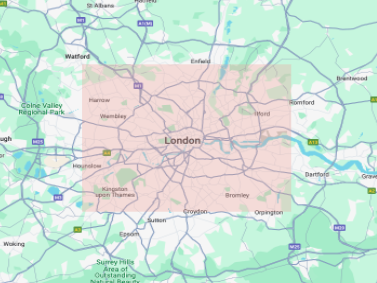
<div class="alert alert-block alert-warning">
<b>Note:</b> the red rectangle here is only meant to demonstrate the selection process, the limits drawn are not exactly the coordinates of the dictionnary below.
</div>

Coordinates from Google Maps:
- London coordinates: 51.5069929036787, -0.12895107981895967
- North limit (Enfield borough): 51.65195042315941, -0.08106613267368643
- West limit (Hillington borough): 51.537921096083025, -0.45221704012735686 
- South limit (Croydon borough): 51.3769109423846, -0.09758628303502302
- East Limit (Upminster): 51.55626396921364, 0.24955389351473162

In [12]:
London_coord = {'North limit (Enfield borough)': [51.65195042315941, -0.08106613267368643],
                'West limit (Hillington borough)': [51.537921096083025, -0.45221704012735686],
                'South limit (Croydon borough)': [51.3769109423846, -0.09758628303502302], 
                'East Limit (Upminster)': [51.55626396921364, 0.24955389351473162]}
London_coord_df = pd.DataFrame(London_coord, index=['Latitude', 'Longitude']).T
London_coord_df

Latitude  Longitude
North limit (Enfield borough)    51.651950  -0.081066
West limit (Hillington borough)  51.537921  -0.452217
South limit (Croydon borough)    51.376911  -0.097586
East Limit (Upminster)           51.556264   0.249554

In [13]:
print(f"Min Lat value: {London_coord_df['Latitude'].min()}")
print(f"Max Lat value: {London_coord_df['Latitude'].max()}")
print(f"Min Lon value: {London_coord_df['Longitude'].min()}")
print(f"Max Lon value: {London_coord_df['Longitude'].max()}")

Min Lat value: 51.3769109423846
Max Lat value: 51.65195042315941
Min Lon value: -0.45221704012735686
Max Lon value: 0.24955389351473162


In [14]:
GLondon_df = df[(df['Latitude_WGS84'] >= London_coord_df['Latitude'].min()) & \
                (df['Latitude_WGS84'] <= London_coord_df['Latitude'].max()) & \
                (df['Longitude_WGS84'] >= London_coord_df['Longitude'].min()) & \
                (df['Longitude_WGS84'] <= London_coord_df['Longitude'].max())]

In [15]:
GLondon_df.describe()

Occurrence_ID                     Start_date  Start_date_day  \
count   1.628870e+05                         162887   162887.000000   
mean    4.165022e+06  2012-10-02 12:11:04.362410752       15.594510   
min     6.000000e+00            2001-03-25 00:00:00        1.000000   
25%     1.829190e+06            2008-07-21 00:00:00        8.000000   
50%     4.888200e+06            2013-07-18 00:00:00       16.000000   
75%     6.374192e+06            2017-08-26 00:00:00       23.000000   
max     8.168492e+06            2020-10-19 00:00:00       31.000000   
std     2.476279e+06                            NaN        8.773763   

       Start_date_month  Start_date_year  Latitude_WGS84  Longitude_WGS84  \
count     162887.000000    162887.000000   162887.000000    162887.000000   
mean           6.709259      2012.240627       51.501557        -0.180515   
min            3.000000      2001.000000       51.379167        -0.440290   
25%            6.000000      2008.000000       51.438260        -0.281758   
50%            7.000000      2013.000000       51.497967        -0.182863   
75%            8.000000      2017.000000       51.562974        -0.034953   
max           10.000000      2020.000000       51.649494         0.124656   
std            1.394315         5.550457        0.073003         0.149540   

            WS_L_Fem       WS_U_Fem       WS_L_Mal       WS_U_Mal  \
count  162887.000000  162887.000000  162887.000000  162887.000000   
mean        3.110379       4.483747       3.599826       4.326599   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.350000       3.800000       3.400000       3.800000   
50%         3.700000       4.500000       3.600000       4.400000   
75%         3.900000       4.700000       3.900000       4.700000   
max         5.900000       7.600000       5.500000       6.700000   
std         1.613779       1.038287       0.875043       1.012160   

                 Jan            Feb            Mar            Apr  \
count  162887.000000  162887.000000  162887.000000  162887.000000   
mean        0.416368       0.498229       0.843603       0.714409   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       0.000000   
50%         0.000000       0.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   
std         0.492958       0.499998       0.363232       0.451697   

                 May            Jun            Jul            Aug  \
count  162887.000000  162887.000000  162887.000000  162887.000000   
mean        0.964970       0.915021       0.989809       0.915021   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   
std         0.183857       0.278852       0.100436       0.278852   

                 Sep            Oct            Nov            Dec  \
count  162887.000000  162887.000000  162887.000000  162887.000000   
mean        0.965160       0.824154       0.408461       0.299214   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   
std         0.183375       0.380690       0.491551       0.457915   

       FlightDuration  NumberOfHostplantFamilies  \
count   162887.000000              162887.000000   
mean         8.754419                   4.187885   
min          0.000000        

In [16]:
print(f'We were able to extract {GLondon_df.shape[0]} Butterfly sightings from Greater London. We will work with those for the Time Series analysis.')

We were able to extract 162887 Butterfly sightings from Greater London. We will work with those for the Time Series analysis.


## Indexing sightings per Year/Month

### Number of sightings per Year/Month

In [17]:
# Counts of sightings per month in London sites selected
Sightings_London = GLondon_df['Year_Month'].value_counts()
Sightings_London = pd.DataFrame(Sightings_London).reset_index().sort_values('Year_Month').set_index('Year_Month')
Sightings_London = Sightings_London.rename(columns={'count':'Sightings'})
Sightings_London.head(3)

Sightings
Year_Month           
2001-03-01         10
2001-04-01        197
2001-05-01        544

In [18]:
# Getting first and last date in the dataframe
print(f'First date: {Sightings_London.index.min()}')
print(f'Last date: {Sightings_London.index.max()}')

First date: 2001-03-01 00:00:00
Last date: 2020-10-01 00:00:00


__COMMENT:__ We will also add dates from Jan-Feb 2001 and Nov-Dec 2020 so as to have full years to compare.

We have a difference of 86 months over 20 years


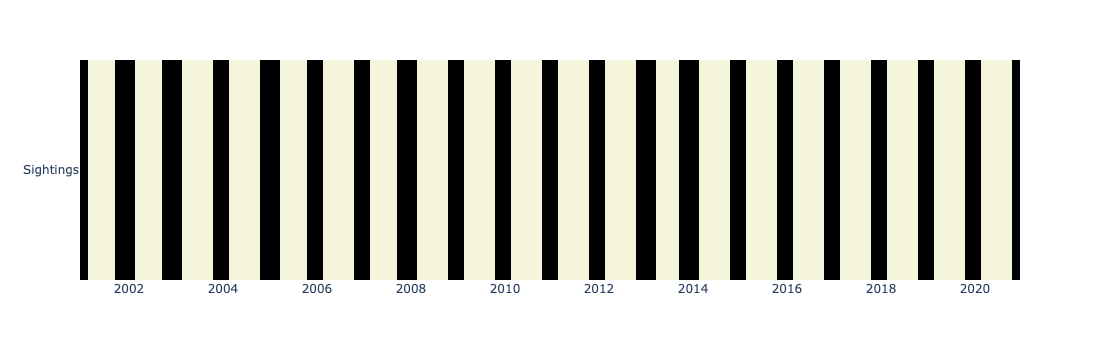

In [19]:
######### Making sure we have values for each month of each year #########

# Getting every months of each year between first and last date in the dataset 
full_index = full_range = pd.date_range(start='2001-01-01', 
                                        end='2020-12-01', 
                                        freq='MS')
diff_month = len(full_index.difference(Sightings_London.index))
print(f'We have a difference of {diff_month} months over 20 years')

# Reindexing sightings dataframe to full range of months
Sightings_London_2 = Sightings_London.reindex(full_index)

# See where the missing values are located
fig = px.imshow(Sightings_London_2.isna().T, color_continuous_scale=['beige', 'black'], height=300, width=1100)
fig.update_layout(coloraxis_showscale=False)
fig.show()

__COMMENT:__ 

- Black stripes = Missing values
- Beige stripes = Butterfly Sightings 

It looks like the missing values are located in the winter time when there is no surveys organised. The best approach to filling the missing values will therefore be to replace with 0.

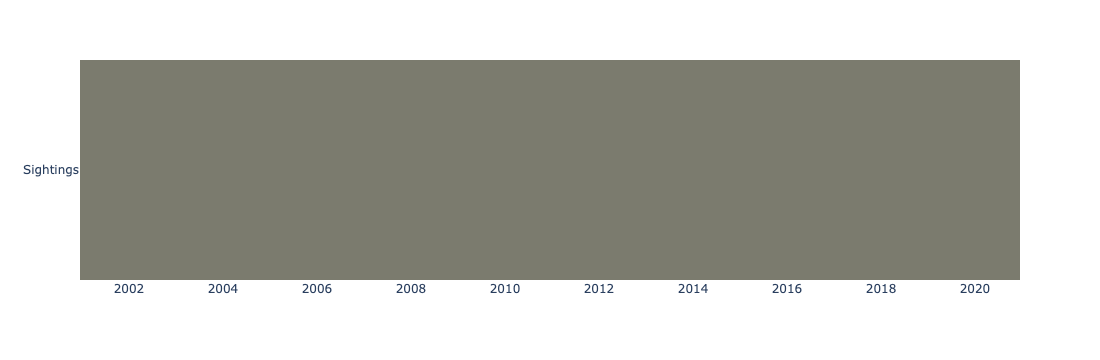

In [20]:
# Filling missing values
Sightings_London_3 = Sightings_London_2.fillna(0) 

# Sanity Check
fig = px.imshow(Sightings_London_3.isna().T, color_continuous_scale=['beige', 'black'], height=300, width=1100)
fig.update_layout(coloraxis_showscale=False)
fig.show()

__COMMENT:__ All missing values have been filled, we can proceed.

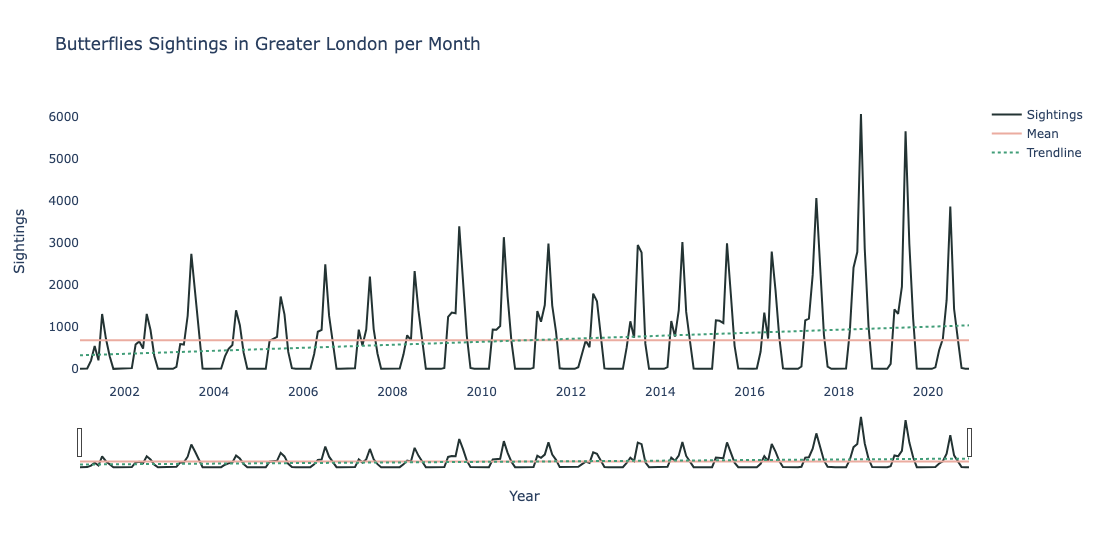

The trendline has an upward slope of about 2.983


In [21]:
# Get Trendline
Sightings_London_3['Order'] = range(len(Sightings_London_3))
X = Sightings_London_3['Order']
y = Sightings_London_3['Sightings']
Sightings_Trendline = sm.OLS(y.values, sm.add_constant(X.values), missing="drop").fit()

# Plot sightings per month
fig = go.Figure()
fig.add_trace(go.Scatter(x=Sightings_London_3.index, 
                         y=Sightings_London_3['Sightings'], 
                         mode='lines', name='Sightings', line=dict(color='#233333')))
fig.add_trace(go.Scatter(x=Sightings_London_3.index, 
                         y=[Sightings_London_3['Sightings'].mean()]*len(Sightings_London_3), 
                         mode='lines', name='Mean', line=dict(color='#EBACA0')))
fig.add_trace(go.Scatter(x=Sightings_London_3.index, 
                         y=Sightings_Trendline.predict(), 
                         mode='lines', name='Trendline', line_dash='dot', line=dict(color='#419D78')))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(yaxis_title='Sightings', xaxis_title='Year',
                  title='Butterflies Sightings in Greater London per Month',
                  width = 1100, height = 550, plot_bgcolor='white', showlegend=True)
# fig.update_layout(xaxis=dict(showgrid=False), yaxis=dict(showgrid=False))
fig.show()

# Trendline parameters
print(f'The trendline has an upward slope of about {round(Sightings_Trendline.params[1],4)}')

__COMMENT:__ We can see on this first plot:

- A clear seasonal pattern, with a peak in the number of Sightings in July/August each year
- An upward trend over the years
- The number of sightings varies from year to year: starting in 2009, we have a clear increase in the number of sightings but we still see two significant drops over the years, in 2012 and 2020 (the first one would need to be researched, the second one most likely due to the pandemic).

### Number of surveys per Year/Month

In [22]:
Num_Surveys = GLondon_df.groupby(['Start_date'])['OSGR'].nunique() #This is counting the number of unique sites ('OSGR') surveyed per day
Num_Surveys = pd.DataFrame(Num_Surveys)
Num_Surveys = Num_Surveys.resample('MS').sum().reindex(full_index).fillna(0)
Num_Surveys = Num_Surveys.rename(columns={'OSGR':'NumSurveys'})
Num_Surveys.head()

NumSurveys
2001-01-01         0.0
2001-02-01         0.0
2001-03-01         2.0
2001-04-01        26.0
2001-05-01        45.0

In [23]:
# Sanity Check
diff_month = len(full_index.difference(Num_Surveys.index))
print(f'We have a difference of {diff_month} months over 20 years')

We have a difference of 0 months over 20 years


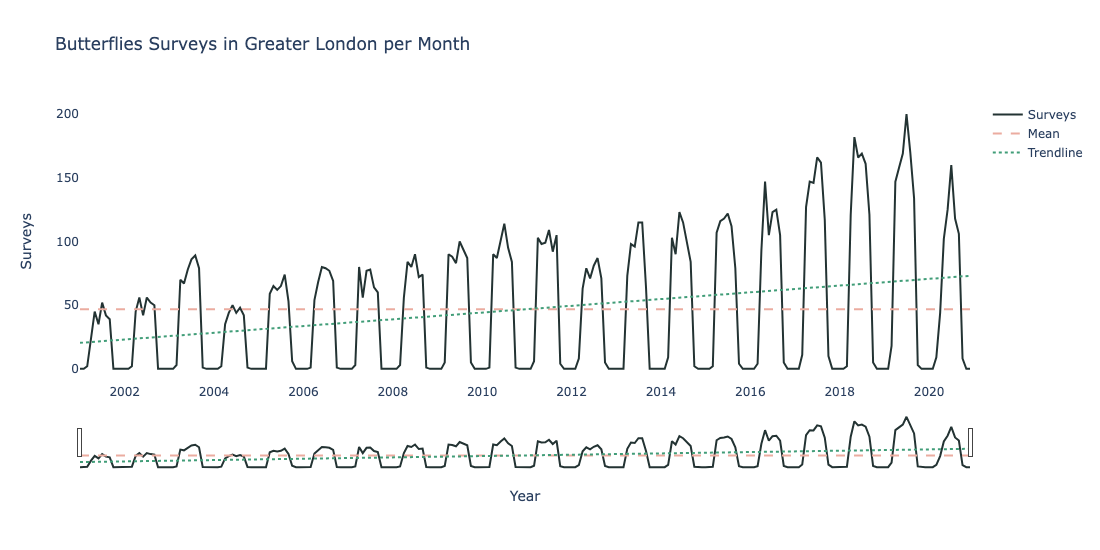

The trendline has an upward slope of about 0.2203


In [24]:
# Get Trendline
Num_Surveys['Order'] = range(len(Num_Surveys))
X = Num_Surveys['Order']
y = Num_Surveys['NumSurveys']
Surveys_Trendline = sm.OLS(y.values, sm.add_constant(X.values), missing="drop").fit()

# Plot surveys per month
fig = go.Figure()
fig.add_trace(go.Scatter(x=Num_Surveys.index, 
                         y=Num_Surveys['NumSurveys'], 
                         mode='lines', name='Surveys', line=dict(color='#233333')))
fig.add_trace(go.Scatter(x=Num_Surveys.index, 
                         y=[Num_Surveys['NumSurveys'].mean()]*len(Num_Surveys), 
                         mode='lines', name='Mean', line_dash='dash', line=dict(color='#EBACA0')))
fig.add_trace(go.Scatter(x=Num_Surveys.index, 
                         y=Surveys_Trendline.predict(), 
                         mode='lines', name='Trendline', line_dash='dot', line=dict(color='#419D78')))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(yaxis_title='Surveys', xaxis_title='Year',
                  title='Butterflies Surveys in Greater London per Month',
                  width = 1100, height = 550, plot_bgcolor='white', showlegend=True)
# fig.add_vrect(x0='2001-01-01', x1='2005-12-01', line_width=0, fillcolor="#EBACA0", opacity=0.2)
fig.show()

# Trendline parameters
print(f'The trendline has an upward slope of about {round(Surveys_Trendline.params[1],4)}')

In [25]:
print(f'In 2001, there were {Num_Surveys.iloc[:12].sum()[0]} surveys conducted, and {Sightings_London_3.iloc[:12].sum()[0]} butterflies seen.')
print(f'In 2020, there were {Num_Surveys.iloc[-12:].sum()[0]} surveys conducted, and {Sightings_London_3.iloc[-12:].sum()[0]} butterflies seen.')

In 2001, there were 241.0 surveys conducted, and 3278.0 butterflies seen.
In 2020, there were 672.0 surveys conducted, and 8842.0 butterflies seen.


__COMMENT:__ We see here that the number of surveys has considerably increased over the years. This means that the butterfly sightings are most likely to increase too, not necessarily because the butterfly population is increasing (although this is also a possibility of course), but because more people are out there counting them.

The idea here is to get an estimation of the butterfly population evolution by taking a constant number of sightings over the years. Aka, if we had:

- First year: 100 surveys, 110 butterflies seen => 1.1 butterfly seen per survey
- Last year: 500 surveys, 600 butterflies seen => 1.2 butterfly seen per survey

To get an idea of how the butterfly population is evolving, we will therefore follow this indicator: number of butterflies seen in each survey.

### Sightings weighted

In [26]:
# Merging the Sightings and Surveys dataframes
Sightings_Surveys = pd.merge(Sightings_London_3, Num_Surveys, 
                             left_index=True, right_index=True)

# Calculting index for each month of every year
Sightings_Surveys['Butterflies_per_Survey'] = round((Sightings_Surveys['Sightings'] / Sightings_Surveys['NumSurveys']),2)
Sightings_Surveys['Butterflies_per_Survey'] = Sightings_Surveys['Butterflies_per_Survey'].fillna(0)
Sightings_Surveys.tail(10)

Sightings  Order_x  NumSurveys  Order_y  Butterflies_per_Survey
2020-03-01       35.0      230         9.0      230                    3.89
2020-04-01      450.0      231        44.0      231                   10.23
2020-05-01      716.0      232       102.0      232                    7.02
2020-06-01     1634.0      233       125.0      233                   13.07
2020-07-01     3863.0      234       160.0      234                   24.14
2020-08-01     1425.0      235       118.0      235                   12.08
2020-09-01      699.0      236       106.0      236                    6.59
2020-10-01       20.0      237         8.0      237                    2.50
2020-11-01        0.0      238         0.0      238                    0.00
2020-12-01        0.0      239         0.0      239                    0.00

In [27]:
############### BASE = Monthly average for the first 5 years ###############
# Merging the Sightings and Surveys dataframes
# Sightings_Surveys = pd.merge(Sightings_London_3, Num_Surveys, 
#                              left_index=True, right_index=True)

# # Extracting month info for future merge with first year surveys numbers
# Sightings_Surveys = Sightings_Surveys.reset_index()
# Sightings_Surveys['Month'] = Sightings_Surveys['index'].dt.month
# Sightings_Surveys = Sightings_Surveys.set_index('index')

# # Isolating number of surveys from first year (will be used to calculate the weight of each month)
# Sightings_Surveys_Base = Sightings_Surveys.iloc[:60,:]
# Sightings_Surveys_Base = Sightings_Surveys_Base.groupby('Month')['NumSurveys'].mean()
# Sightings_Surveys_Base = np.tile(Sightings_Surveys_Base.values, 20)

# # Add 2001 number of Surveys per month over each year in the dataset
# Sightings_Surveys['Surveys_Base'] = Sightings_Surveys_Base

# # # Calculting index for each month of every year
# Sightings_Surveys['Weight'] = round((Sightings_Surveys['NumSurveys'] / Sightings_Surveys['Surveys_Base']),2)
# Sightings_Surveys['Sightings_Weighted'] = round(Sightings_Surveys['Sightings'] / Sightings_Surveys['Weight'],2)
# Sightings_Surveys['Sightings_Weighted'] = Sightings_Surveys['Sightings_Weighted'].fillna(0)
# Sightings_Surveys.tail(10)

In [28]:
############### BASE = Moving average ###############
# # Merging the Sightings and Surveys dataframes
# Sightings_Surveys = pd.merge(Sightings_London_3, Num_Surveys, 
#                              left_index=True, right_index=True)

# # Add moving average
# # Code help: https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/
# window_size = 12
# i = 0
# Surveys_Base = [0] * 11 # Adding 0 as first values to have a matching length with dataset

# while i < len(Sightings_Surveys) - window_size + 1:
   
#     # Store elements from i to i+window_size in list to get the current window
#     window = Sightings_Surveys.iloc[i : i + window_size, 1] #column[1] = 'NumSurveys'
 
#     # Calculate the average of current window
#     window_average = round(sum(window) / window_size, 2)
     
#     # Store the average of current window in moving average list
#     Surveys_Base.append(window_average)
     
#     # Shift window to right by one position
#     i += 1

# # Add Moving Average of Surveys per month over each year in the dataset
# Sightings_Surveys['Surveys_Base'] = Surveys_Base

# # # Calculting index for each month of every year
# Sightings_Surveys['Weight'] = round((Sightings_Surveys['NumSurveys'] / Sightings_Surveys['Surveys_Base']),2)
# Sightings_Surveys['Sightings_Weighted'] = round(Sightings_Surveys['Sightings'] / Sightings_Surveys['Weight'],2)
# Sightings_Surveys['Sightings_Weighted'] = Sightings_Surveys['Sightings_Weighted'].fillna(0)
# Sightings_Surveys.tail(10)

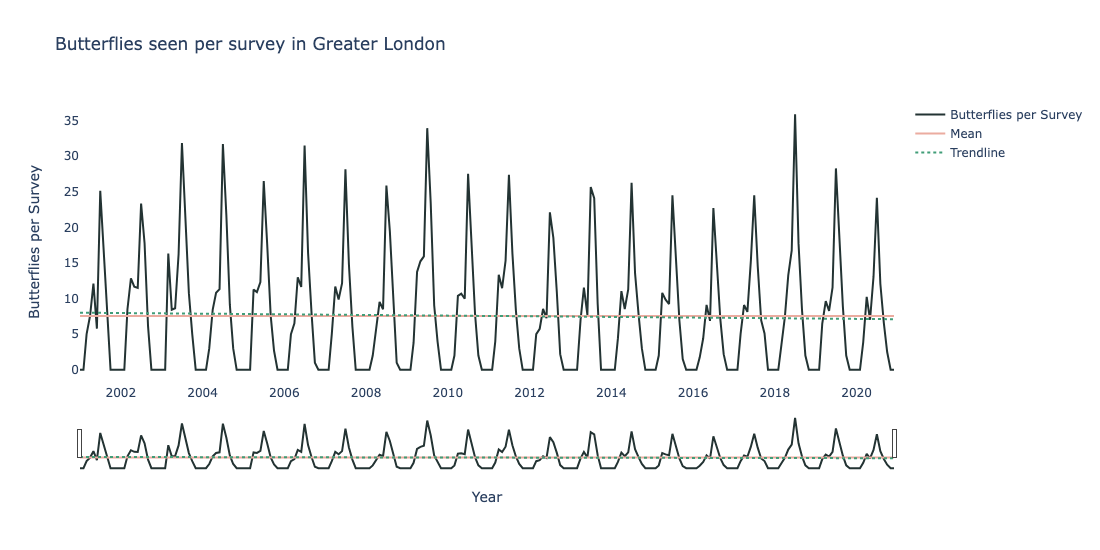

The trendline has a downward slope of about -0.0038


In [29]:
# Get Trendline
Sightings_Surveys['Order'] = range(len(Sightings_Surveys))
X = Sightings_Surveys['Order']
y = Sightings_Surveys['Butterflies_per_Survey']
Butterflies_per_Survey_Trendline = sm.OLS(y.values, sm.add_constant(X.values), missing="drop").fit()

# Plot sightings weighted per month
fig = go.Figure()
fig.add_trace(go.Scatter(x=Sightings_Surveys.index, 
                         y=Sightings_Surveys['Butterflies_per_Survey'], 
                         mode='lines', name='Butterflies per Survey', line=dict(color='#233333')))
fig.add_trace(go.Scatter(x=Sightings_Surveys.index, 
                         y=[Sightings_Surveys['Butterflies_per_Survey'].mean()]*len(Sightings_Surveys), 
                         mode='lines', name='Mean', line=dict(color='#EBACA0')))
fig.add_trace(go.Scatter(x=Sightings_Surveys.index, 
                         y=Butterflies_per_Survey_Trendline.predict(), 
                         mode='lines', name='Trendline', line_dash='dot', line=dict(color='#419D78')))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(yaxis_title='Butterflies per Survey', xaxis_title='Year',
                  title='Butterflies seen per survey in Greater London',
                  width = 1100, height = 550, plot_bgcolor='white', showlegend=True)
fig.show()

# Trendline parameters
print(f'The trendline has a downward slope of about {round(Butterflies_per_Survey_Trendline.params[1],4)}')

__COMMENT:__ We can see here a very slight trend downward. Now, we will explore further the time series to understand how trend / seasonality / residuals are actually working here.

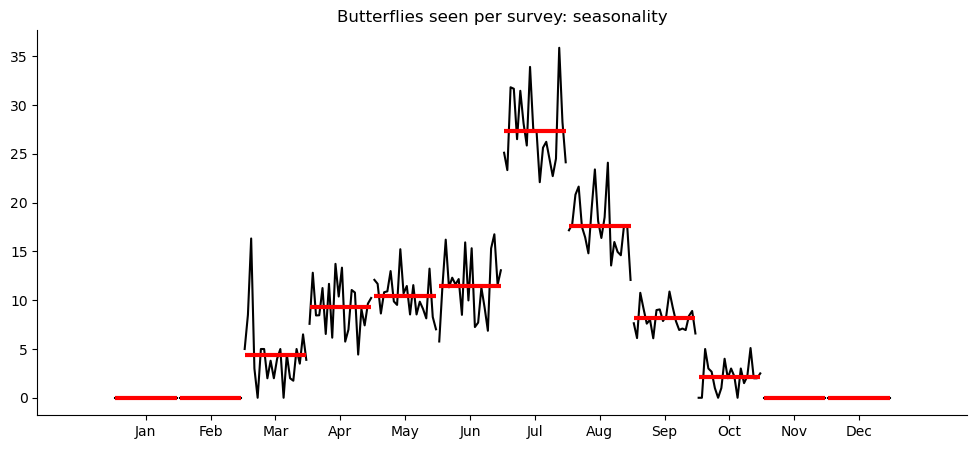

In [30]:
# Creating a seasonal plot
plt.figure(figsize=(12, 5))
month_plot(Sightings_Surveys['Butterflies_per_Survey'], ax=plt.gca())
plt.title('Butterflies seen per survey: seasonality')
sns.despine()
plt.show()

In [31]:
decomposition = tsa.seasonal_decompose(Sightings_Surveys['Butterflies_per_Survey'], model='additive')
Sightings_Surveys['Trend'] = decomposition.trend
Sightings_Surveys['Seasonal'] = decomposition.seasonal
Sightings_Surveys['Residuals'] = decomposition.resid
Sightings_Surveys.head(5)

Sightings  Order_x  NumSurveys  Order_y  Butterflies_per_Survey  \
2001-01-01        0.0        0         0.0        0                    0.00   
2001-02-01        0.0        1         0.0        1                    0.00   
2001-03-01       10.0        2         2.0        2                    5.00   
2001-04-01      197.0        3        26.0        3                    7.58   
2001-05-01      544.0        4        45.0        4                   12.09   

            Order  Trend  Seasonal  Residuals  
2001-01-01      0    NaN -7.641226        NaN  
2001-02-01      1    NaN -7.627915        NaN  
2001-03-01      2    NaN -3.313924        NaN  
2001-04-01      3    NaN  1.761844        NaN  
2001-05-01      4    NaN  2.697940        NaN

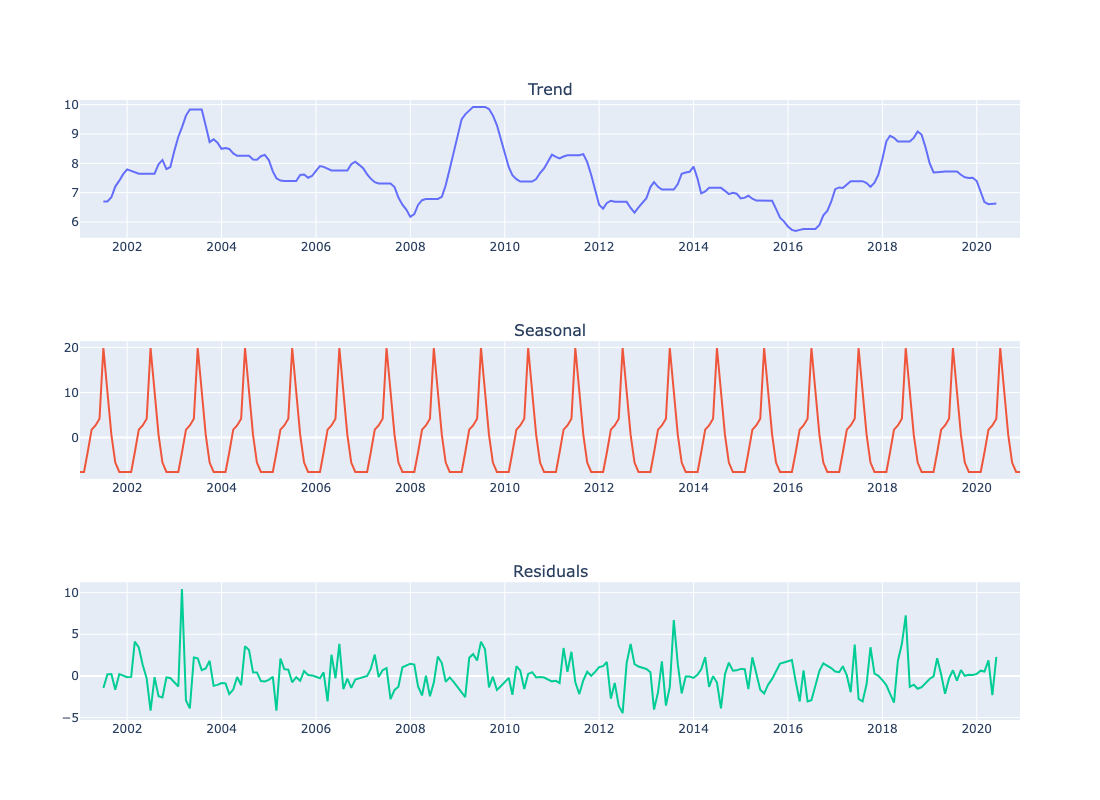

In [32]:
cols = ['Trend', 'Seasonal', 'Residuals']

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=Sightings_Surveys.index, y=Sightings_Surveys[col]),
        row=i+1,
        col=1)

fig.update_layout(height=800, width=1150, showlegend=False)
fig.show()

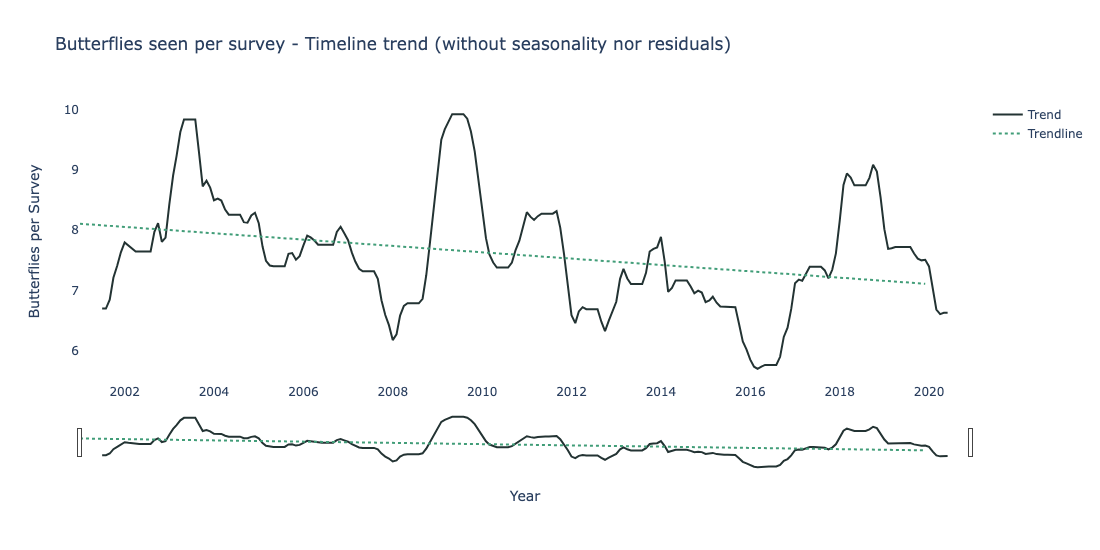

The trendline has a downward slope of about -0.0044


In [33]:
# Get Trendline for trend only
X = Sightings_Surveys['Order']
y = Sightings_Surveys['Trend']
Trend_Trendline = sm.OLS(y.values, sm.add_constant(X.values), missing="drop").fit()

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=Sightings_Surveys.index, 
                         y=Sightings_Surveys['Trend'], 
                         mode='lines', name='Trend', line=dict(color='#233333')))
fig.add_trace(go.Scatter(x=Sightings_Surveys.index, 
                         y=Trend_Trendline.predict(), 
                         mode='lines', name='Trendline', line_dash='dot', line=dict(color='#419D78')))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(yaxis_title='Butterflies per Survey', xaxis_title='Year',
                  title='Butterflies seen per survey - Timeline trend (without seasonality nor residuals)',
                  width = 1100, height = 550, plot_bgcolor='white', showlegend=True)
fig.show()

# Trendline parameters
print(f'The trendline has a downward slope of about {round(Trend_Trendline.params[1],4)}')

__COMMENT:__

# Time Series Models

## Train / Test Split

__COMMENT:__ We are splitting the dataset 75/25% (aka 75% of all the rows = 180 datapoints), in chronological order.

In [34]:
print(len(Sightings_Surveys)*.75)
train = Sightings_Surveys['Butterflies_per_Survey'].iloc[:180]
test = Sightings_Surveys['Butterflies_per_Survey'].iloc[180:]

180.0


## Baseline model: SARIMA

### Finding best parameters

In [35]:
Sightings_Surveys['Year_Diff'] = Sightings_Surveys['Butterflies_per_Survey'].diff(12)
Sightings_Surveys.head()

Sightings  Order_x  NumSurveys  Order_y  Butterflies_per_Survey  \
2001-01-01        0.0        0         0.0        0                    0.00   
2001-02-01        0.0        1         0.0        1                    0.00   
2001-03-01       10.0        2         2.0        2                    5.00   
2001-04-01      197.0        3        26.0        3                    7.58   
2001-05-01      544.0        4        45.0        4                   12.09   

            Order  Trend  Seasonal  Residuals  Year_Diff  
2001-01-01      0    NaN -7.641226        NaN        NaN  
2001-02-01      1    NaN -7.627915        NaN        NaN  
2001-03-01      2    NaN -3.313924        NaN        NaN  
2001-04-01      3    NaN  1.761844        NaN        NaN  
2001-05-01      4    NaN  2.697940        NaN        NaN

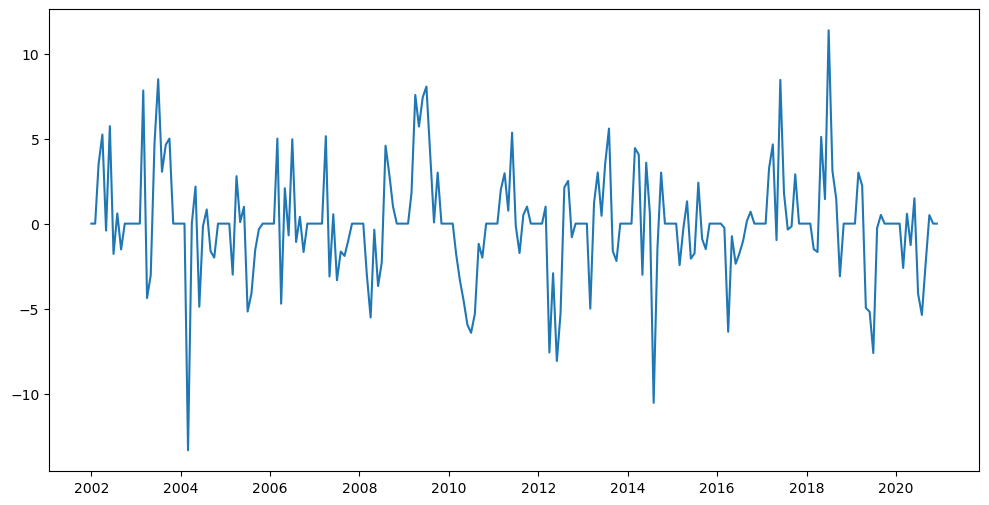

In [36]:
plt.figure(figsize=(12,6))
plt.plot(Sightings_Surveys['Year_Diff'])
plt.show()

In [37]:
# Testing stationarity
DickeyFullerTest = adfuller(Sightings_Surveys['Year_Diff'].dropna(),12)
print('Statistic Test : ', DickeyFullerTest[0])
print('p-value : ', DickeyFullerTest[1])
print('n_lags : ', DickeyFullerTest[2])

Statistic Test :  -5.240853598130063
p-value :  7.251618143814745e-06
n_lags :  12


__COMMENT:__

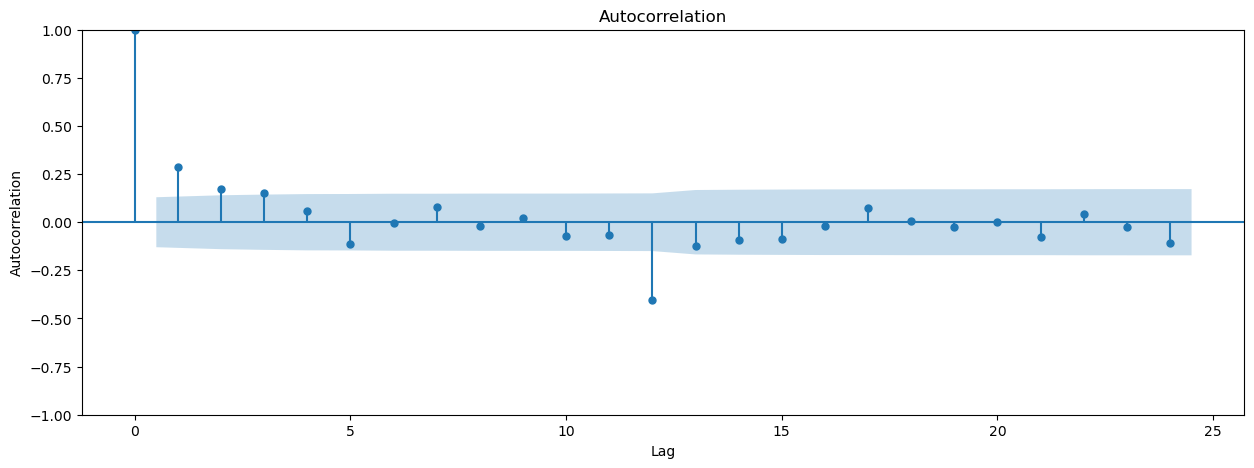

In [38]:
# A CONFIRMER !
plt.figure(figsize=(15, 5))
plot_acf(Sightings_Surveys['Year_Diff'].dropna(), lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

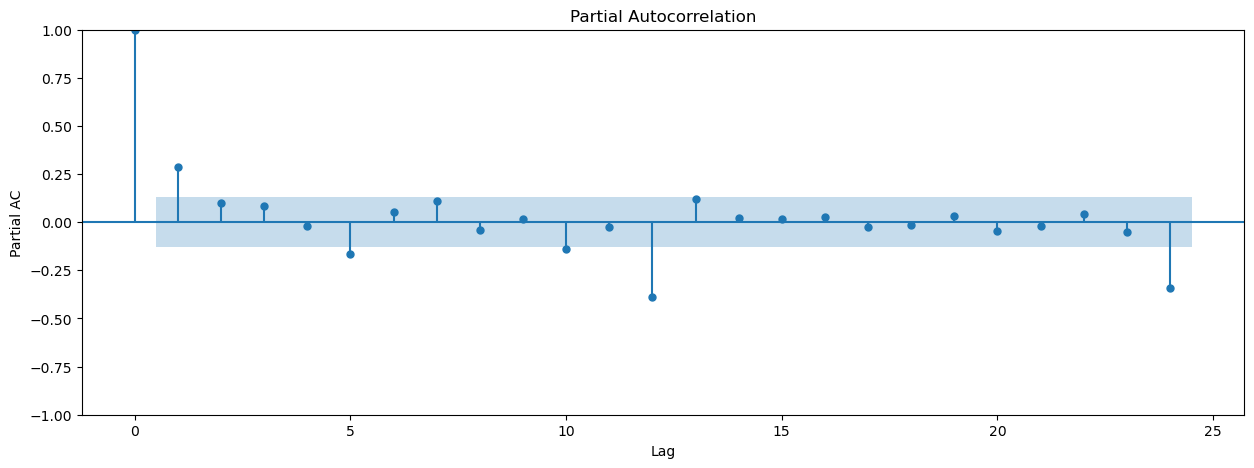

In [39]:
plt.figure(figsize=(15, 5))
plot_pacf(Sightings_Surveys['Year_Diff'].dropna(), lags=24, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

__COMMENT:__ Given the ACF and PCAF plots above we can infer that the best parameters would be:

- p:
- d:
- q:
- ...

To confirm this, we will also run an auto_arima function which will look through the best combos possible and select the one with the lowest AIC.

In [40]:
model_test = pm.auto_arima(train, m = 12, D=1, seasonal = True, trace = True)
model_test.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=870.868, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=825.013, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=868.869, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=859.531, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=798.680, Time=0.34 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=775.220, Time=0.59 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=788.364, Time=0.41 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=776.168, Time=0.58 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=775.413, Time=0.75 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=777.424, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -381.222
Date:                            Mon, 25 Mar 2024   AIC                            774.444
Time:                                    21:49:19   BIC                            793.188
Sample:                                01-01-2001   HQIC                           782.051
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6270      0.183      3.426      0.001       0.268       0.986
ma.L1         -0.3553      0.215     -1.654      0.098      -0.776       0.066
ar.S.L12      -0.1234      0.081     -1.515      0.130      -0.283       0.036
ar.S.L24      -0.2201      0.079     -2.783      0.005      -0.375      -0.065
ma.S.L12      -0.7571      0.094     -8.019      0.000      -0.942      -0.572
sigma2         4.9668      0.460     10.803      0.000       4.066       5.868
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.63
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.26
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model

In [41]:
# Model
sarima = SARIMAX(train, order=(1, 0, 1), seasonal_order=(2, 1, 1, 12), trend='c')
sarima_fit = sarima.fit(disp=0)
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             Butterflies_per_Survey   No. Observations:                  180
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -380.707
Date:                            Mon, 25 Mar 2024   AIC                            775.413
Time:                                    21:49:20   BIC                            797.281
Sample:                                01-01-2001   HQIC                           784.288
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0387      0.047     -0.828      0.407      -0.130       0.053
ar.L1          0.6011      0.193      3.109      0.002       0.222       0.980
ma.L1         -0.3362      0.223     -1.505      0.132      -0.774       0.102
ar.S.L12      -0.1193      0.082     -1.453      0.146      -0.280       0.042
ar.S.L24      -0.2183      0.079     -2.768      0.006      -0.373      -0.064
ma.S.L12      -0.7738      0.096     -8.099      0.000      -0.961      -0.587
sigma2         4.9137      0.452     10.873      0.000       4.028       5.799
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                18.94
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.24
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Evaluation

In [42]:
# Evaluation - First defining a function to calculate the Mean Absolute Percentage Error (will serve to evaluate scores across models)
def mean_absolute_percentage_error(true_values, predicted_values):
    """
    Calculate the mean absolute percentage error. 
    Find the prediction error and devide by the true value, then average.
    """
    
    error = true_values - predicted_values
    absolute_percentage_error = np.abs(error/true_values)
    absolute_percentage_error = absolute_percentage_error.replace(np.inf, 0)    
    mape = absolute_percentage_error.mean() * 100
    return mape

In [43]:
# Evaluation - Models Results
predictions = sarima_fit.predict(start=0, end=len(train)+len(test))

train_mape = mean_absolute_percentage_error(train, predictions[train.index])
test_mape = mean_absolute_percentage_error(test, predictions[test.index])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 20.63%
Test MAPE on the difference: 18.27%


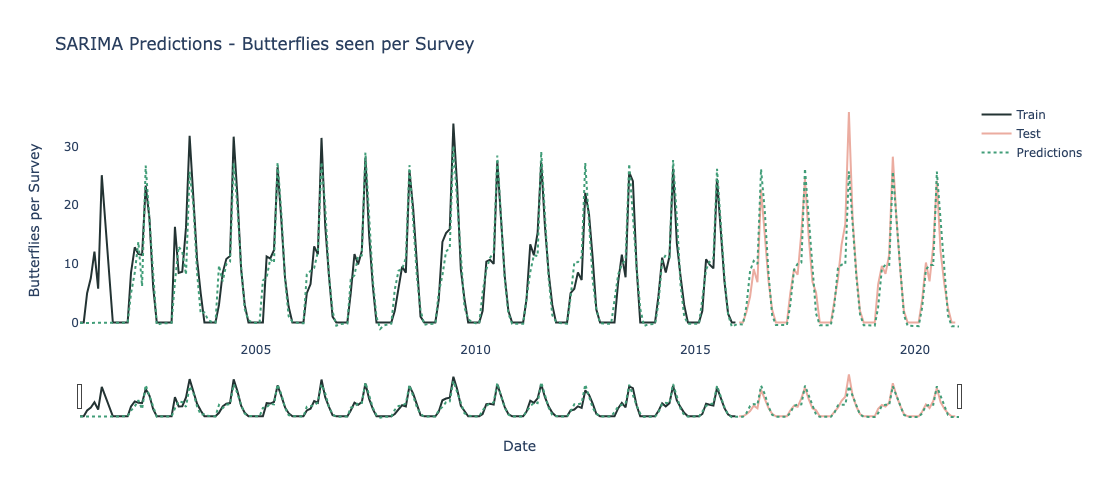

In [44]:
# Plotting True values and Predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', line=dict(color='#233333'), name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', line=dict(color='#EBACA0'), name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', line_dash='dot', 
                         line=dict(color='#419D78'), name="Predictions"))

fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(yaxis_title="Butterflies per Survey", xaxis_title="Date", 
                  title="SARIMA Predictions - Butterflies seen per Survey",
                  width=1100, height=500, plot_bgcolor='white', showlegend=True)
fig.show()

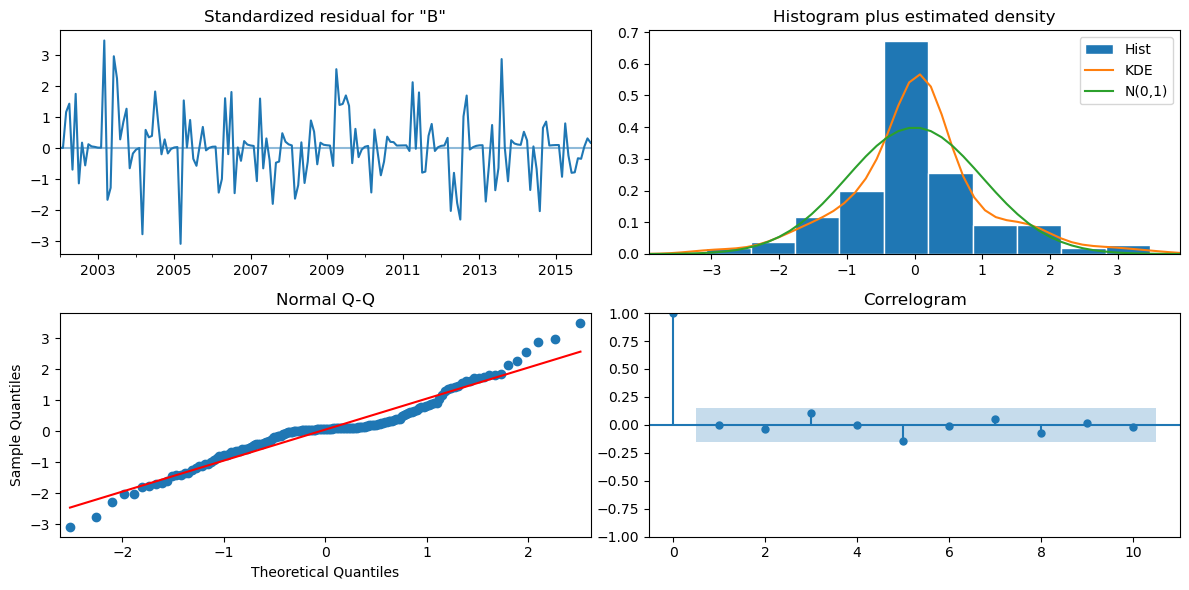

In [45]:
# Evaluation - Plot residuals
sarima_fit.plot_diagnostics(figsize=(12,6))
plt.tight_layout()
plt.show()

### Forecasts

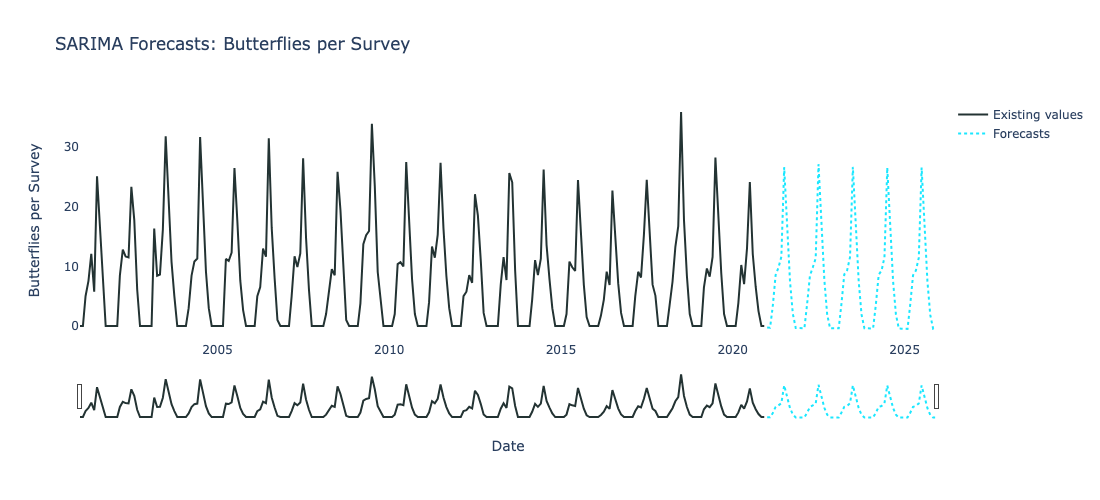

In [46]:
# Fit model on whole dataset using same parameters as before
sarima_forecast = SARIMAX(Sightings_Surveys['Butterflies_per_Survey'], order=(1, 0, 1), seasonal_order=(2, 1, 1, 12), trend='c')
sarima_forecast_fit = sarima_forecast.fit(disp=0)
sarima_forecast_fit.summary()

# Forecasting
forecast_sarima = sarima_forecast_fit.forecast(steps=60)

# Plotting Forecasts
fig = go.Figure()
fig.add_trace(go.Scatter(x=Sightings_Surveys['Butterflies_per_Survey'].index, y=Sightings_Surveys['Butterflies_per_Survey'], 
                         mode='lines', line=dict(color='#233333'), name='Existing values'))
fig.add_trace(go.Scatter(x=forecast_sarima.index, y=forecast_sarima, mode='lines', line_dash='dot', 
                         line=dict(color='#1BE7FF'), name="Forecasts"))

fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(yaxis_title="Butterflies per Survey", xaxis_title="Date", 
                  title="SARIMA Forecasts: Butterflies per Survey",
                  width=1100, height=500, plot_bgcolor='white', showlegend=True)
fig.show()

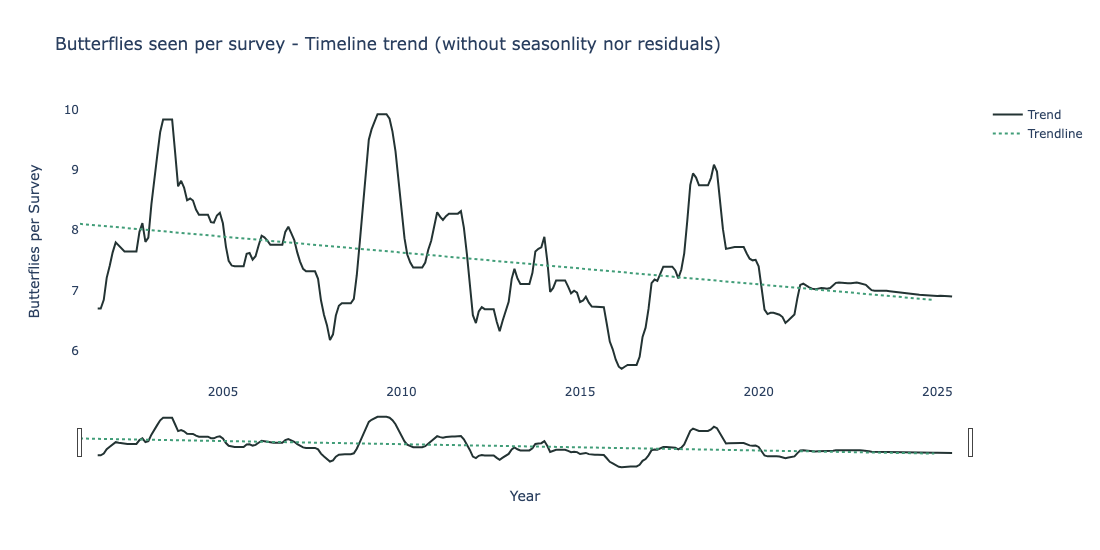

The trendline has a downward slope of about -0.0044


In [47]:
# Concatenate 
current_values = pd.DataFrame(Sightings_Surveys['Butterflies_per_Survey'])
forecast_sarima = pd.DataFrame(forecast_sarima)
test = pd.concat([current_values, forecast_sarima])
test['Combined'] = np.where(test['Butterflies_per_Survey'].isna()==True, test['predicted_mean'], test['Butterflies_per_Survey'])

# Add Order info for linear regression (instead of datetime)
test['Order'] = range(len(test))

# Seasonal decompose
decomposition = tsa.seasonal_decompose(test['Combined'], model='additive')
test['Trend'] = decomposition.trend
test['Seasonal'] = decomposition.seasonal
test['Residuals'] = decomposition.resid

# Get Trendline for trend only
X = test['Order']
y = test['Trend']
Trend_Forecast_Trendline = sm.OLS(y.values, sm.add_constant(X.values), missing="drop").fit()

# Plot Trend
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, 
                         y=test['Trend'], 
                         mode='lines', name='Trend', line=dict(color='#233333')))
fig.add_trace(go.Scatter(x=test.index, 
                         y=Trend_Forecast_Trendline.predict(), 
                         mode='lines', name='Trendline', line_dash='dot', line=dict(color='#419D78')))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(yaxis_title='Butterflies per Survey', xaxis_title='Year',
                  title='Butterflies seen per survey - Timeline trend (without seasonlity nor residuals)',
                  width = 1100, height = 550, plot_bgcolor='white', showlegend=True)
fig.show()

# Trendline parameters
print(f'The trendline has a downward slope of about {round(Trend_Forecast_Trendline.params[1],4)}')

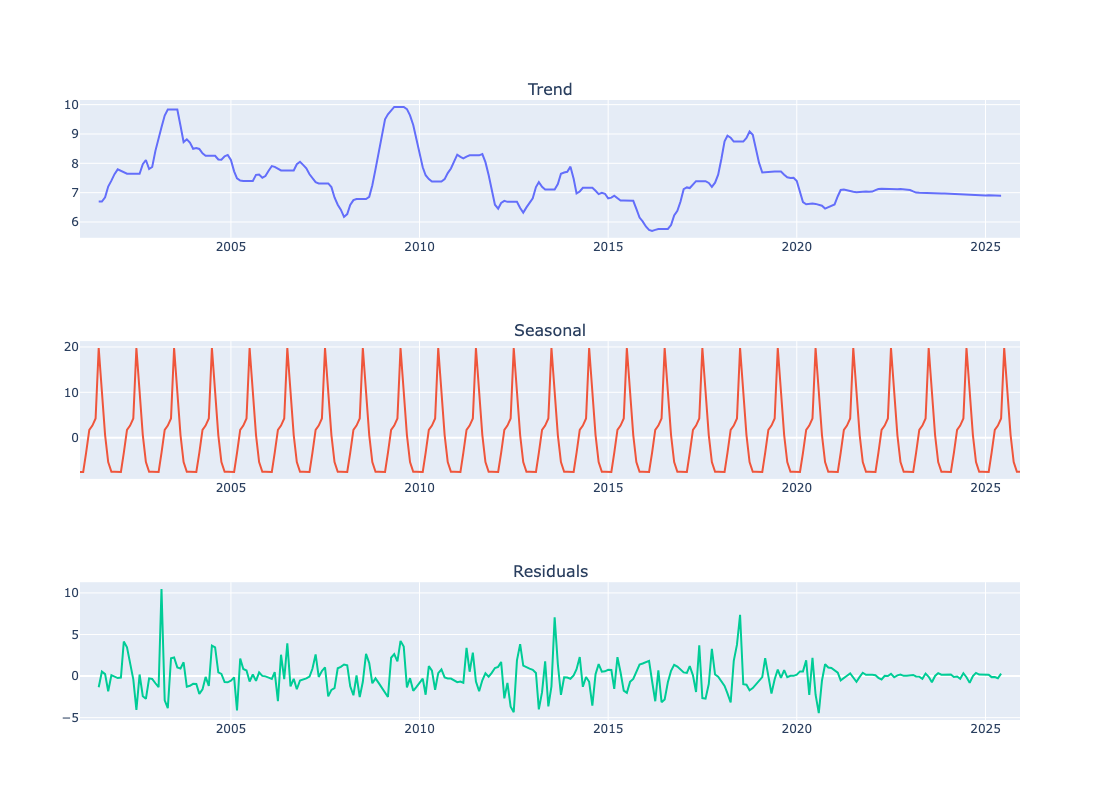

In [48]:
cols = ['Trend', 'Seasonal', 'Residuals']

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=test.index, y=test[col]),
        row=i+1,
        col=1)

fig.update_layout(height=800, width=1150, showlegend=False)
fig.show()

# Next steps - Personal notes

- Butterfly data:
    - Regroup sightings London by week or month (depending on external info found)
    - Transform into index? Log?
    - EDA - Describe observations:
        - Missing data points?
        - Note that we can't have duplicated rows
        - Make sure we have complete years (from March to Feb)
        - Exclude 2020 for pandemic? first years?
        - General trend
        - Seasonal pattern (cross info with flight duration?)
    - Baseline model: Univariate model SARIMAX
- Find average data external info London:
    - Datasets:
        - Air quality: which pollutant to consider?
        - Weather: Temperatures, rainfall, wind, ...
    - Scale?
    - Multivariate models:
        - Check stationarity (Dickey–Fuller test)
        - VAR model (captures seasonality - needed?) / mSSA / Prophet / LSTM? / Kats? / Random forest? => Each needs stationarity?
        - Test causality (!! data needs to be non stationnary?)
        - Tune with predictions for external factors (Net Zero / Air quality... depending on which var is predictive of B pop)

<div class="alert alert-block alert-info">
<b>Questions:</b> 
    Multivariate models: Do you need to specify different lag per metric (like temperature has an impact 2 months after, pollutant 1 month after...)?
</div>

__NOTE__: how many months / year do we want to predict?

- Gather data about positive efforts towards environement in London:
    - Butterfly conservation efforts
    - No emission zone start dates
- Study by species:
    - Trend by species? Scatter coeff trend VS each LepTraits?
    - Group by vulnerability? Scatter London coeff trend VS UK vulnerability group? (attention: Zoom on London)

# _Tests

## Var Model

In [49]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
mdata = sm.datasets.macrodata.load_pandas().data
mdata.head()

year  quarter   realgdp  realcons  realinv  realgovt  realdpi    cpi  \
0  1959.0      1.0  2710.349    1707.4  286.898   470.045   1886.9  28.98   
1  1959.0      2.0  2778.801    1733.7  310.859   481.301   1919.7  29.15   
2  1959.0      3.0  2775.488    1751.8  289.226   491.260   1916.4  29.35   
3  1959.0      4.0  2785.204    1753.7  299.356   484.052   1931.3  29.37   
4  1960.0      1.0  2847.699    1770.5  331.722   462.199   1955.5  29.54   

      m1  tbilrate  unemp      pop  infl  realint  
0  139.7      2.82    5.8  177.146  0.00     0.00  
1  141.7      3.08    5.1  177.830  2.34     0.74  
2  140.5      3.82    5.3  178.657  2.74     1.09  
3  140.0      4.33    5.6  179.386  0.27     4.06  
4  139.6      3.50    5.2  180.007  2.31     1.19

In [50]:
# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly.head()

0    1959Q1
1    1959Q2
2    1959Q3
3    1959Q4
4    1960Q1
dtype: object

In [51]:
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)
quarterly

[datetime.datetime(1959, 3, 31, 0, 0),
 datetime.datetime(1959, 6, 30, 0, 0),
 datetime.datetime(1959, 9, 30, 0, 0),
 datetime.datetime(1959, 12, 31, 0, 0),
 datetime.datetime(1960, 3, 31, 0, 0),
 datetime.datetime(1960, 6, 30, 0, 0),
 datetime.datetime(1960, 9, 30, 0, 0),
 datetime.datetime(1960, 12, 31, 0, 0),
 datetime.datetime(1961, 3, 31, 0, 0),
 datetime.datetime(1961, 6, 30, 0, 0),
 datetime.datetime(1961, 9, 30, 0, 0),
 datetime.datetime(1961, 12, 31, 0, 0),
 datetime.datetime(1962, 3, 31, 0, 0),
 datetime.datetime(1962, 6, 30, 0, 0),
 datetime.datetime(1962, 9, 30, 0, 0),
 datetime.datetime(1962, 12, 31, 0, 0),
 datetime.datetime(1963, 3, 31, 0, 0),
 datetime.datetime(1963, 6, 30, 0, 0),
 datetime.datetime(1963, 9, 30, 0, 0),
 datetime.datetime(1963, 12, 31, 0, 0),
 datetime.datetime(1964, 3, 31, 0, 0),
 datetime.datetime(1964, 6, 30, 0, 0),
 datetime.datetime(1964, 9, 30, 0, 0),
 datetime.datetime(1964, 12, 31, 0, 0),
 datetime.datetime(1965, 3, 31, 0, 0),
 datetime.datetime(

In [52]:
In [10]: mdata = mdata[['realgdp','realcons','realinv']]
mdata.head()

realgdp  realcons  realinv
0  2710.349    1707.4  286.898
1  2778.801    1733.7  310.859
2  2775.488    1751.8  289.226
3  2785.204    1753.7  299.356
4  2847.699    1770.5  331.722

In [53]:
import pandas 
mdata.index = pandas.DatetimeIndex(quarterly)
mdata.head()

realgdp  realcons  realinv
1959-03-31  2710.349    1707.4  286.898
1959-06-30  2778.801    1733.7  310.859
1959-09-30  2775.488    1751.8  289.226
1959-12-31  2785.204    1753.7  299.356
1960-03-31  2847.699    1770.5  331.722

In [54]:
import numpy as np
data = np.log(mdata).diff().dropna()
data.tail()

realgdp  realcons   realinv
2008-09-30 -0.006781 -0.008948 -0.017836
2008-12-31 -0.013805 -0.007843 -0.069165
2009-03-31 -0.016612  0.001511 -0.175598
2009-06-30 -0.001851 -0.002196 -0.067561
2009-09-30  0.006862  0.007265  0.020197

In [55]:
model = VAR(data)

In [56]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 25, Mar, 2024
Time:                     21:49:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

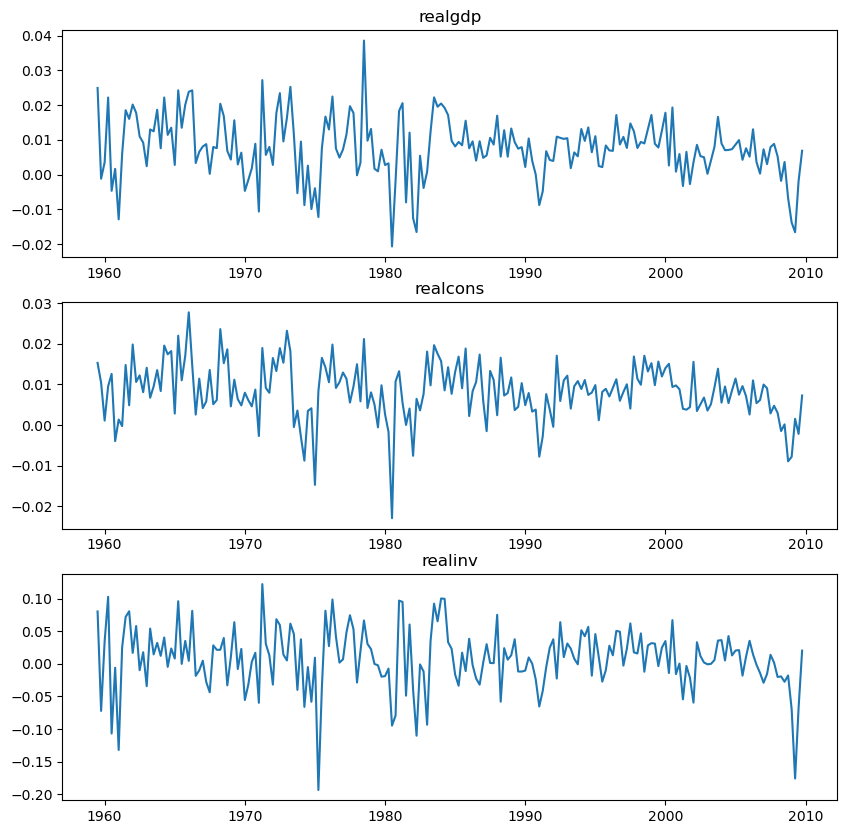

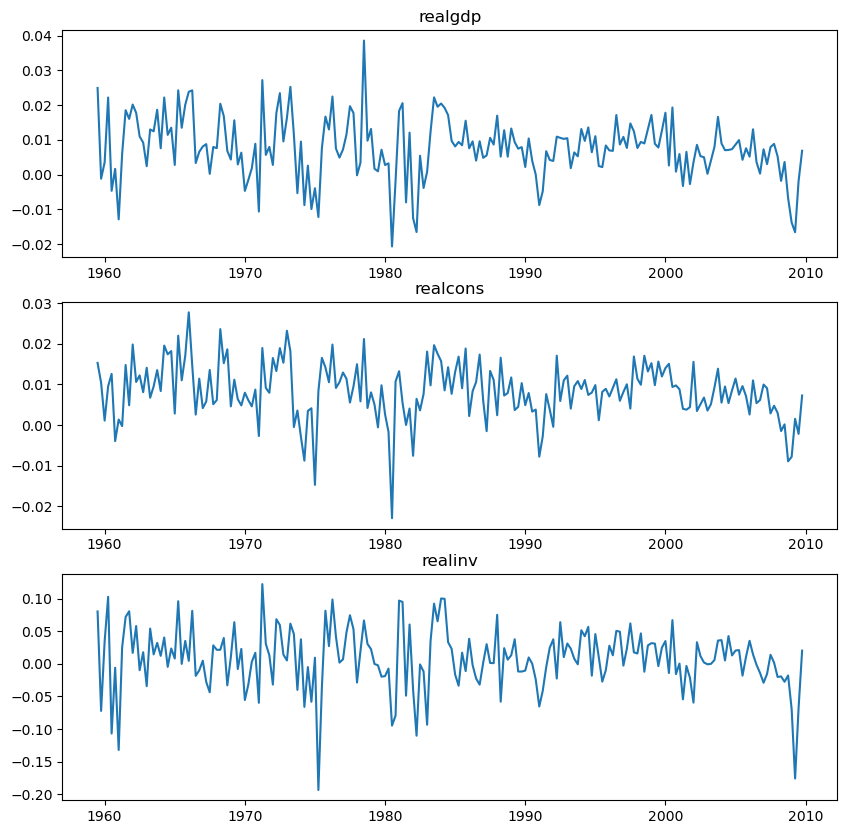

In [57]:
results.plot()

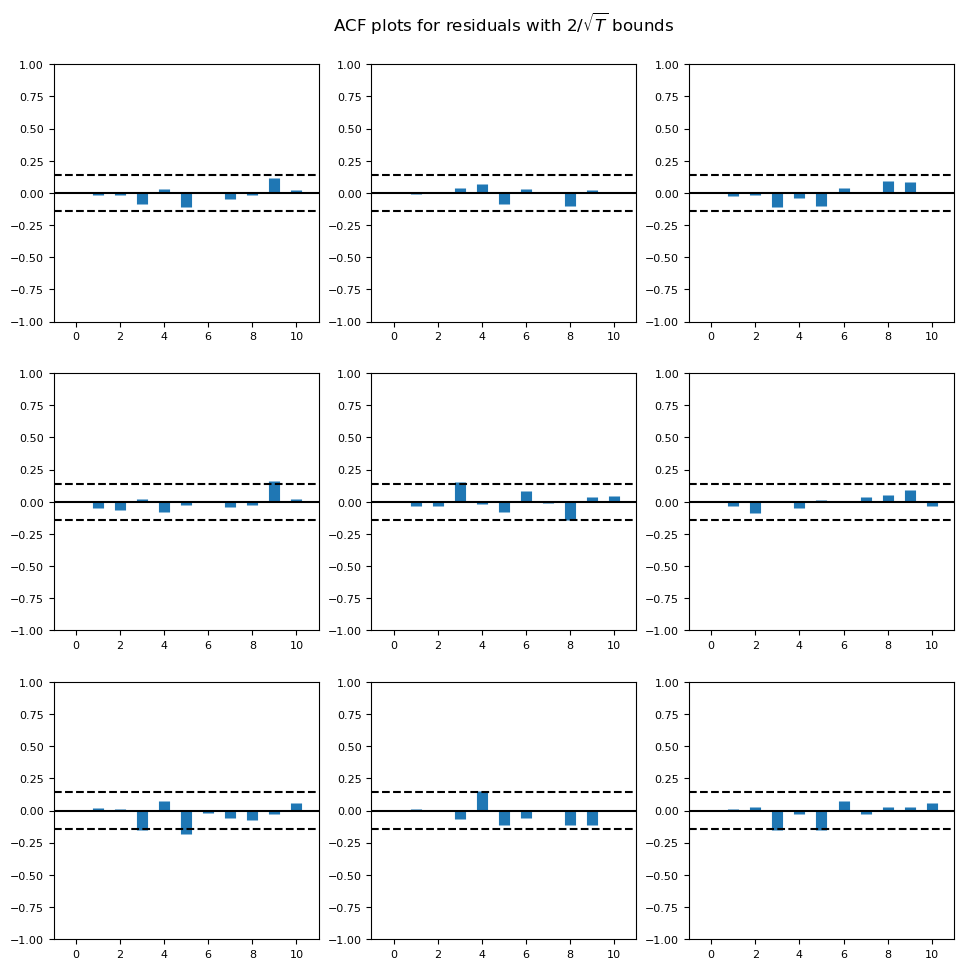

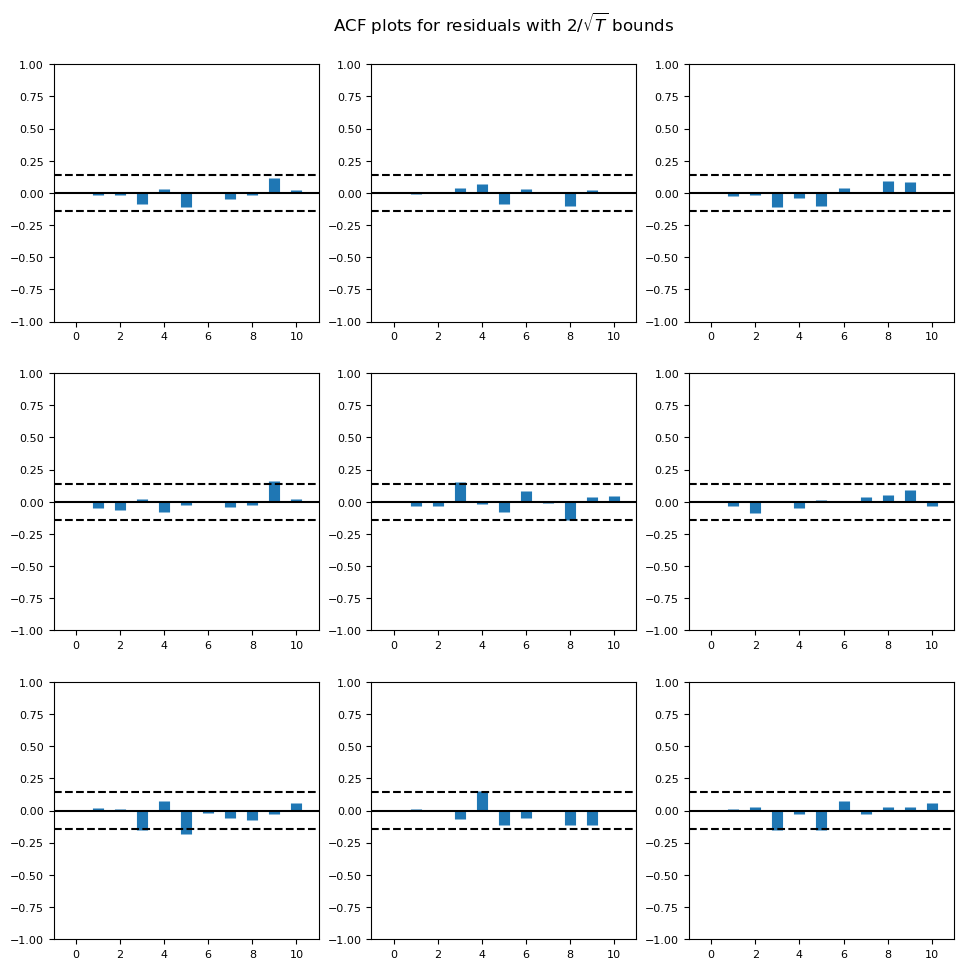

In [58]:
results.plot_acorr()

In [59]:
model.select_order(15)

In [60]:
results.test_causality('realgdp', ['realinv', 'realcons'], kind='wald', signif=0.9)

# _Archives

## D3 - UK Weighted Sightings

In [61]:
# df_Sightings_Year_Weighted = pd.read_csv('data/Sightings_year_weighted.csv')

# df_Sightings_Year_Weighted.head()

# df_Sightings_Year_Weighted.shape

# df_Sightings_Year_Weighted['Start_date_year'].min()
# df_Sightings_Year_Weighted['Start_date_year'].max()

## Weather / Sightings correlation?

Notes: Test with London temperatures for whole UK Sightings - need to be updated to UK weather data

In [62]:
# df_london_weather2 = df_london_weather[(df_london_weather['yyyy'] >= 2001) & (df_london_weather['yyyy'] <= 2020)]
# df_london_weather2

# df_london_weather2 = pd.DataFrame(df_london_weather2.groupby('yyyy')['tmax'].mean()).reset_index()

# # Merge Sightings and Weather
# df_Sightings_Year_Weighted2 = pd.merge(df_Sightings_Year_Weighted, df_london_weather2, left_on='Start_date_year', right_on='yyyy', 
#                                        how='left')

# df_Sightings_Year_Weighted2 = df_Sightings_Year_Weighted2.drop(columns=['Unnamed: 0', 'index', 'count', 'weight', 'yyyy'])

# # Plot
# plt.subplots(1,2, figsize=[15,6])

# plt.subplot(1,2,1)
# plt.plot(df_Sightings_Year_Weighted2['Start_date_year'], df_Sightings_Year_Weighted2['tmax'])
# plt.title('Temperatures')

# plt.subplot(1,2,2)
# plt.plot(df_Sightings_Year_Weighted2['Start_date_year'], df_Sightings_Year_Weighted2['counts_weighted'])
# plt.title('Weighted sightings')

# plt.tight_layout()
# plt.show()

# # Corr
# sns.heatmap(df_Sightings_Year_Weighted2.corr(), annot=True)

# stats.pearsonr(df_Sightings_Year_Weighted2['tmax'], df_Sightings_Year_Weighted2['counts_weighted'])

# stats.pearsonr(df_Sightings_Year_Weighted2['tmax'], df_Sightings_Year_Weighted2['Start_date_year'])